---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the Jupyter Notebook FAQ course resource._

---

# Assignment 4 - Predicting and understanding viewer engagement with educational videos 

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners. This assignment gives you an example of how machine learning can be used to address part of that challenge.

## About the prediction problem

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, your task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

We chose this prediction problem for several reasons:

* It combines a variety of features derived from a rich set of resources connected to the original data;
* The manageable dataset size means the dataset and supervised models for it can be easily explored on a wide variety of computing platforms;
* Predicting popularity or engagement for a media item, especially combined with understanding which features contribute to its success with viewers, is a fun problem but also a practical representative application of machine learning in a number of business and educational sectors.


## About the dataset

We extracted training and test datasets of educational video features from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single educational video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

Note: Any extra variables that may be included in the training set are simply for your interest if you want an additional source of data for visualization, or to enable unsupervised and semi-supervised approaches. However, they are not included in the test set and thus cannot be used for prediction. **Only the data already included in your Coursera directory can be used for training the model for this assignment.**

For this final assignment, you will bring together what you've learned across all four weeks of this course, by exploring different prediction models for this new dataset. In addition, we encourage you to apply what you've learned about model selection to do hyperparameter tuning using training/validation splits of the training data, to optimize the model and further increase its performance. In addition to a basic evaluation of model accuracy, we've also provided a utility function to visualize which features are most and least contributing to the overall model performance.

**File descriptions** 
    assets/train.csv - the training set (Use only this data for training your model!)
    assets/test.csv - the test set
<br>

**Data fields**

train.csv & test.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.
    

## Evaluation

Your predictions will be given as the probability that the corresponding video will be engaging to learners.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model with an AUC (area under ROC curve) of at least 0.8 passes this assignment, and over 0.85 will receive full points.
___

For this assignment, create a function that trains a model to predict significant learner engagement with a video using `asset/train.csv`. Using this model, return a Pandas Series object of length 2309 with the data being the probability that each corresponding video from `readonly/test.csv` will be engaging (according to a model learned from the 'engagement' label in the training set), and the video index being in the `id` field.

Example:

    id
       9240    0.401958
       9241    0.105928
       9242    0.018572
                 ...
       9243    0.208567
       9244    0.818759
       9245    0.018528
             ...
       Name: engagement, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out and check your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. 

* Try to avoid global variables. If you have other functions besides engagement_model, you should move those functions inside the scope of engagement_model.

* Be sure to first check the pinned threads in Week 4's discussion forum if you run into a problem you can't figure out.

### Extensions

* If this prediction task motivates you to explore further, you can find more details here on the original VLE dataset and others related to video engagement: https://github.com/sahanbull/VLE-Dataset



In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   # Do not change this value: required to be compatible with solutions generated by the autograder.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)

def engagement_model():
    rec = None
    train_path = 'assets/train.csv'
    test_path = 'assets/test.csv'
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    features = [
        'title_word_count', 
        'document_entropy', 
        'freshness', 
        'easiness', 
        'fraction_stopword_presence', 
        'speaker_speed', 
        'silent_period_rate'
    ]
    
    X = train_df[features]
    y = train_df['engagement']
    
    X_test = test_df[features]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_scaled = scaler.transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest Classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=100, 
        random_state=0,
        class_weight='balanced' 
    )
    rf_classifier.fit(X_train_scaled, y_train)
    
    # Predicting probabilities on validation set
    val_probs = rf_classifier.predict_proba(X_val_scaled)[:, 1]
    
    # Calculating ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, val_probs)
    roc_auc = roc_auc_score(y_val, val_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, val_probs)
    avg_precision = average_precision_score(y_val, val_probs)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    rf_classifier_full = RandomForestClassifier(
        n_estimators=100, 
        random_state=0,
        class_weight='balanced' 
    )
    rf_classifier_full.fit(X_scaled, y)
    
    test_probs = rf_classifier_full.predict_proba(X_test_scaled)[:, 1]
    
    print("First 5 probabilities:", test_probs[:5])
    
    rec = pd.Series(test_probs, index=test_df['id'], name='engagement')
    
    print("\nProbability Distribution:")
    print(rec.describe())
    print(rec)
    return rec

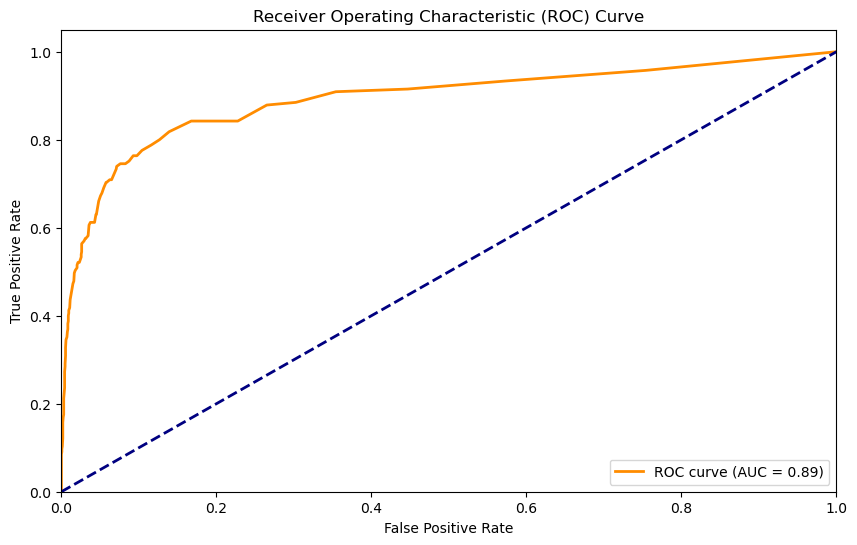

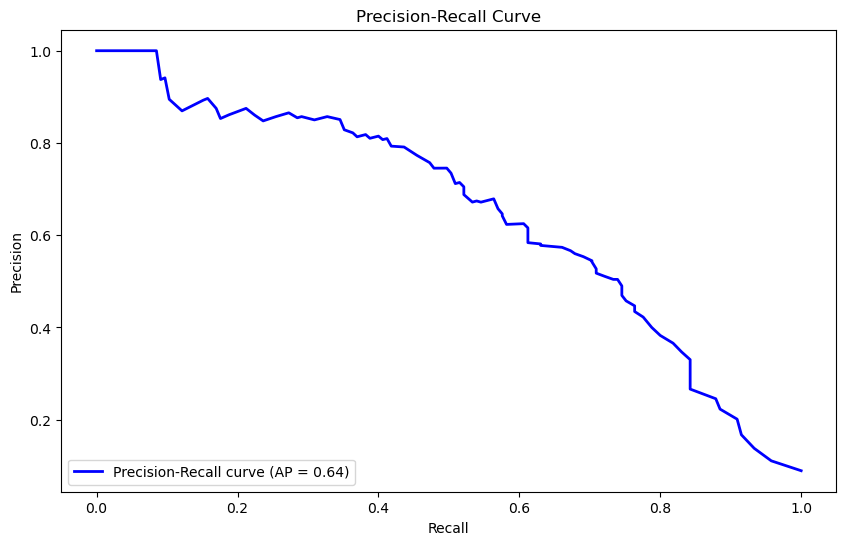

First 5 probabilities: [0.   0.06 0.07 0.8  0.02]

Probability Distribution:
count    2309.000000
mean        0.099186
std         0.186342
min         0.000000
25%         0.010000
50%         0.020000
75%         0.080000
max         0.970000
Name: engagement, dtype: float64
id
9240     0.00
9241     0.06
9242     0.07
9243     0.80
9244     0.02
         ... 
11544    0.01
11545    0.00
11546    0.01
11547    0.90
11548    0.01
Name: engagement, Length: 2309, dtype: float64


In [20]:
stu_ans = engagement_model()
assert isinstance(stu_ans, pd.Series), "Your function should return a pd.Series. "
assert len(stu_ans) == 2309, "Your series is of incorrect length: expected 2309 "
assert np.issubdtype(stu_ans.index.dtype, np.integer), "Your answer pd.Series should have an index of integer type representing video id."